In this notebook comparable models for predicting exacerbations will be benchmarked against the models developed in this thesis. The models of interest are:
* ADO: age, dyspnoea, obstruction (https://www.dovepress.com/external-validation-of-the-updated-ado-score-in-copd-patients-from-the-peer-reviewed-fulltext-article-COPD)
* BODE: bmi, obstruction, dyspnoea, exercise capacity (https://www.mdcalc.com/calc/3916/bode-index-copd-survival#evidence)
* DOSE: dyspnoea, obstruction, smoking, exacerbations (https://www.nature.com/articles/pcrj201254/tables/1)
* BCSS: breathlessness, cough, sputum scale (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5131613/)
* previous exacerbations alone (current clinical standard)
* Bertens: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Preparing Data

In [2]:
exaggerate = pd.read_csv('exaggerate/data/working_sheet.csv', sep=";")

# Harvard

In this section we are defining all the variables we need from the harvard dataset and are constructing a dataframe from all the baseline recordings

In [3]:
# prepare datasets
harvard = pd.read_csv('harvard/data/Original Data/original_data.csv', sep=";")

target = "fclinra08"

print(harvard.shape)

relevant_vars = [
    'dem02', # age
    'dem03', # gender
    'bclinra01', # height
    'bclinra02', # weight
    'bclinpt04', # hypertension
    'bclinpt15', # diabetes
    'mmrc', # modified medical research council dyspnoea scale
    'bclinpt07', # heart failure
    'bclinpt34',  # fever
    'bclinpt28',  # dyspnoea
    'login', # unique patient identified
    'bclinpt19', # cancer
    'bclinpt08', # myocardial infarct
    'bclinpt09', # stroke or TIA
    'bclinpt38', # chronic kidney disease
    'bclinpt32', # wheezing
    'bclinra11', # patients gold category
    'bclinra07', # current COPD state as confirmed by clinician
    'psqi09', # cough snore
    'sgrq02', # cough four weeks
    'sgrq03', # bring up sputum
    'exact4', # how difficult sputum
    'exact3', # how much sputum
    'sgrq05', # wheezing attacks
    'sgrq09', # wheeze morning
    'bclinra101', # fev1
    'bclinra202c_2',  # percent fev1 pred
    'bclinra202c_5', # percent fev1 pred
    'psqi06', # waking up at night
    'bclinpt14', # asthma
    'bclinpt11' , # chronic kidney disease
    'bclinpt26', # icu last year
    'bclinpt24', # hospital last year
    'bclinpt43', # medication copd
    'bclinpt44', # other antibiotic
    'bclinpt45', # other medication
    'bclinra06', # medication copd 2
    'bclinra06_1024', # other copd medication
    'bclinra06_512', # qvar
    'bclinra06_256', # azmacort
    'bclinra06_128', # pulmicort
    'bclinra06_64', # flovent
    'bclinra06_32', # floradil
    'bclinra06_16', # serevent
    'bclinra06_8', # spiriva
    'bclinra06_4', # combivent
    'bclinra06_2', # atrovent
    'bclinra06_1', # proventil
    'exact2', # cough today
    'bclinpt22', # previous exacerbations
    'bclinpt06', # ischemic heart disease
    'sgrq04', # shortness of breath past 4 weeks
    'elig09', # pack years
    'bclinra14', # 6MWT
    target]

harvard = harvard[relevant_vars]
print(harvard.columns.tolist())
harvard = harvard.rename(columns={
    "mmrc": "mmrc", 
    "dem02": "age", 
    "bclinra202c_2": "percent_fev1_1", 
    "bclinra202c_5": "percent_fev1_2", 
    "fclinra08": "exacerbation", 
    'bclinra14': '6MWT', 
    'bclinra01':'height', 
    'bclinra02':'weight', 
    'bclinpt22': 'prev_exacerbations', 
    'dem03': 'gender', 
    'bclinpt19': 'cancer', 
    'bclinpt04': 'hypertension', 
    'bclinpt15': 'diabetes', 
    'bclinpt07': 'heart_failure', 
    'bclinra01': 'height', 
    'bclinra02': 'weight', 
    'bclinpt34': 'fever',  
    'bclinpt08':'myocardial_infarct', 
    'bclinpt09':'stroke', 
    'bclinpt28':'dyspnoea', 
    'bclinpt36': 'fast_breathing', 'elig09':'pack_years',
    'bclinpt14': 'asthma',
    'bclinpt11': 'chronic_kidney_disease',
    'bclinpt26': 'icu_last_year',
    'bclinpt24': 'hospitalizations_last_year',
    'bclinpt43': 'medication_copd',
    'bclinpt44': 'other_antibiotic',
    'bclinpt45': 'other_medication',
    'bclinra06': 'medication_copd_2',
    'bclinra06_1024': 'other_copd_medication',
    'bclinra06_512': 'qvar',
    'bclinra06_256': 'azmacort',
    'bclinra06_128': 'pulmicort',
    'bclinra06_64': 'flovent',
    'bclinra06_32': 'foradil',
    'bclinra06_16': 'serevent',
    'bclinra06_8': 'spiriva',
    'bclinra06_4': 'combivent',
    'bclinra06_2': 'atrovent',
    'bclinra06_1': 'proventil',
    'psqi06': 'waking_up_at_night',
    'exact2': 'cough_today',
    'psqi09': 'cough_snore',
    'sgrq02': 'cough_four_weeks',
    'sgrq20': 'cough_hurts',
    'sgrq21': 'cough_tired',
    'bclinra101': 'fev1',
    'bclinra14': '6MWT',
    })

print(harvard.columns.tolist())

# get the baseline
# get all unique values in the login column
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])
# turn lists into dataframes but with columns from harvard dataset
harvard = pd.DataFrame(baseline, columns=harvard.columns)
harvard = harvard.drop(columns=['login'], axis=1)
print(harvard.columns.tolist())


# TODO implement proper pre-processing here

# make mmrc start at 0
harvard['mmrc'] = harvard['mmrc'] - 1
# get rid of all rows with exacerbation = 3
harvard = harvard[harvard['exacerbation'] != 3]
# make exacerbation start at 0
harvard['exacerbation'] = harvard['exacerbation'] - 1
# if exacerbation is 1, make it 0 and vice versa
harvard['exacerbation'] = 1 - harvard['exacerbation']
# create percent_fev1 column
harvard['percent_fev1'] = harvard['percent_fev1_1']
# if percent_fev1_1 is nan, use percent_fev1_2
harvard.loc[harvard['percent_fev1_1'].isnull(), 'percent_fev1'] = harvard['percent_fev1_2']
# if percent_fev1_2 is larger than percent_fev1_1, use percent_fev1_2 for percent_fev1
harvard.loc[harvard['percent_fev1_2'] > harvard['percent_fev1_1'], 'percent_fev1'] = harvard['percent_fev1_2']
# drop percent_fev1_1 and percent_fev1_2
harvard = harvard.drop(['percent_fev1_1', 'percent_fev1_2'], axis=1)

# drop all rows where exacerbation is nan
harvard = harvard.dropna(subset=['exacerbation'])

# turn exacerbation into integer from float
harvard['exacerbation'] = harvard['exacerbation'].astype(int)
#print nan values
print(harvard.isnull().sum())

(2796, 926)
['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34', 'bclinpt28', 'login', 'bclinpt19', 'bclinpt08', 'bclinpt09', 'bclinpt38', 'bclinpt32', 'bclinra11', 'bclinra07', 'psqi09', 'sgrq02', 'sgrq03', 'exact4', 'exact3', 'sgrq05', 'sgrq09', 'bclinra101', 'bclinra202c_2', 'bclinra202c_5', 'psqi06', 'bclinpt14', 'bclinpt11', 'bclinpt26', 'bclinpt24', 'bclinpt43', 'bclinpt44', 'bclinpt45', 'bclinra06', 'bclinra06_1024', 'bclinra06_512', 'bclinra06_256', 'bclinra06_128', 'bclinra06_64', 'bclinra06_32', 'bclinra06_16', 'bclinra06_8', 'bclinra06_4', 'bclinra06_2', 'bclinra06_1', 'exact2', 'bclinpt22', 'bclinpt06', 'sgrq04', 'elig09', 'bclinra14', 'fclinra08']
['age', 'gender', 'height', 'weight', 'hypertension', 'diabetes', 'mmrc', 'heart_failure', 'fever', 'dyspnoea', 'login', 'cancer', 'myocardial_infarct', 'stroke', 'bclinpt38', 'bclinpt32', 'bclinra11', 'bclinra07', 'cough_snore', 'cough_four_weeks', 'sgrq03', 'exact4', 'exact3',

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\1291967088.py:2: DtypeWarning: Columns (3,26,218,247,251) have mixed types. Specify dtype option on import or set low_memory=False.
  harvard = pd.read_csv('harvard/data/Original Data/original_data.csv', sep=";")


### Harvard Preprocessing

In this section subselections depending on the model and the needed predictors are being made. Depending on variable selection. Missing values may be handled differently. Essentially the best preprocessing techniques are performed for the given set of predictors and model that they are being used for

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\9504646.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1


## ADO

The ADO uses age in years, dyspnoea (mMRC scale) and FEV1 % predicted

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
# TODO we need to not only take the baseline data but the data in between that has been collected


# drop all rows where the required parameters are nan
ado = harvard.dropna(subset=['percent_fev1'])
# create a column for ADO score
ado['ADO'] = 0
# if age is between 50 and 59 add 2 points
ado.loc[(ado['age'] >= 50) & (ado['age'] <= 59), 'ADO'] += 2
# if age is between 60 and 69 add 4 points
ado.loc[(ado['age'] >= 60) & (ado['age'] <= 69), 'ADO'] += 4
# if age is between 70 and 79 add 5 points
ado.loc[(ado['age'] >= 70) & (ado['age'] <= 79), 'ADO'] += 5
# if age is above 80 add 7 points
ado.loc[ado['age'] >= 80, 'ADO'] += 7
# if mmrc is 3 add 2 points
ado.loc[ado['mmrc'] == 3, 'ADO'] += 2
# if mmrc is 4 add 3 points
ado.loc[ado['mmrc'] == 4, 'ADO'] += 3
# if fev1% is between 51 and 64 add 2 points
ado.loc[(ado['percent_fev1'] >= 51) & (ado['percent_fev1'] <= 64), 'ADO'] += 2
# if fev1% is between 36 and 50 add 3 points
ado.loc[(ado['percent_fev1'] >= 36) & (ado['percent_fev1'] <= 50), 'ADO'] += 3
# if fev1% is smaller than 35 add 4 points
ado.loc[ado['percent_fev1'] < 35, 'ADO'] += 4

# get best cutoff for ADO score
ado_cutoffs = np.linspace(0, ado['ADO'].max(), 100)
ado_scores = []
for cutoff in ado_cutoffs:
    y = ado['exacerbation']
    y_pred = np.where(ado['ADO'] > cutoff, 1, 0)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # calculate AUC score from TPR and FPR
    auc_score = auc(fpr, tpr)
    # add AUC score to list
    ado_scores.append(auc_score)
# get the cutoff with the highest AUC score
best_ado_cutoff = ado_cutoffs[ado_scores.index(max(ado_scores))]
# print the cutoff
print('ADO cutoff: ' + str(best_ado_cutoff))
print('ADO AUC score: ' + str(max(ado_scores)))

ADO cutoff: 7.090909090909092
ADO AUC score: 0.5901360544217686


C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\1551383044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ado['ADO'] = 0


## BODE

In [6]:
# drop all rows where the required parameters are nan
bode = harvard.dropna(subset=['percent_fev1'])
bode = bode.dropna(subset=['6MWT'])
bode = bode.dropna(subset=['height'])
bode = bode.dropna(subset=['weight'])

# create a column for BODE score
bode['BODE'] = 0

bode.loc[(bode['percent_fev1'] >= 50) & (bode['percent_fev1'] <= 64), 'BODE'] += 1
bode.loc[(bode['percent_fev1'] >= 36) & (bode['percent_fev1'] <= 49), 'BODE'] += 2
bode.loc[(bode['percent_fev1'] <= 35), 'BODE'] += 3

bode.loc[(bode['mmrc'] == 2), 'BODE'] += 1
bode.loc[(bode['mmrc'] == 3), 'BODE'] += 2
bode.loc[(bode['mmrc'] == 4), 'BODE'] += 3

# calculate bmi
bode['bmi'] = bode['weight'] / ((bode['height'] / 100) ** 2)
# drop height and weight
bode = bode.drop(['height', 'weight'], axis=1)
bode.loc[(bode['bmi'] <= 21), 'BODE'] += 1

bode.loc[(bode['6MWT'] >= 250) & (bode['6MWT'] <= 349), 'BODE'] += 1
bode.loc[(bode['6MWT'] >= 150) & (bode['6MWT'] <= 249), 'BODE'] += 2
bode.loc[(bode['6MWT'] <= 149), 'BODE'] += 3

print(bode['BODE'].value_counts())


# get best cutoff for BODE score
bode_cutoffs = np.linspace(0, bode['BODE'].max(), 100)
bode_scores = []
for cutoff in bode_cutoffs:
    y = bode['exacerbation']
    y_pred = np.where(bode['BODE'] > cutoff, 1, 0)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # calculate AUC score from TPR and FPR
    auc_score = auc(fpr, tpr)
    # add AUC score to list
    bode_scores.append(auc_score)
# get the cutoff with the highest AUC score
best_bode_cutoff = bode_cutoffs[bode_scores.index(max(bode_scores))]
# print the cutoff
print('ADO cutoff: ' + str(best_bode_cutoff))
print('ADO AUC score: ' + str(max(bode_scores)))


3    15
2    14
1    13
4    10
0     8
5     8
6     7
7     2
8     1
9     1
Name: BODE, dtype: int64
ADO cutoff: 2.0
ADO AUC score: 0.6873015873015873


## DOSE
Dose is calculated from mMRC, FEV1% pred, smoking status, exacerbations in previous year

In [33]:
dose = harvard.dropna(subset=['percent_fev1'])
dose = dose.dropna(subset=['mmrc'])
dose = dose.dropna(subset=['prev_exacerbations'])

dose['DOSE'] = 0

dose.loc[(dose['mmrc'] == 2), 'DOSE'] += 1
dose.loc[(dose['mmrc'] == 3), 'DOSE'] += 2
dose.loc[(dose['mmrc'] == 4), 'DOSE'] += 3

dose.loc[(dose['percent_fev1'] >= 30) & (dose['percent_fev1'] <= 49), 'DOSE'] += 1
dose.loc[(dose['percent_fev1'] < 30), 'DOSE'] += 2

# all participants in harvard study were smokers
dose['DOSE'] += 1

# prev exacerbations is badly categorized. For now we assume that category 3 (between 2 and 5 exacerbations) is mostly 2 - 3 exacerbations
dose.loc[(dose['prev_exacerbations'] == 3), 'DOSE'] += 2

# get best cutoff for DOSE score
dose_cutoffs = np.linspace(0, dose['DOSE'].max(), 100)
dose_scores = []
for cutoff in dose_cutoffs:
    y = dose['exacerbation']
    y_pred = np.where(dose['DOSE'] > cutoff, 1, 0)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # calculate AUC score from TPR and FPR
    auc_score = auc(fpr, tpr)
    # add AUC score to list
    dose_scores.append(auc_score)
# get the cutoff with the highest AUC score
best_dose_cutoff = dose_cutoffs[dose_scores.index(max(dose_scores))]
# print the cutoff
print('DOSE cutoff: ' + str(best_dose_cutoff))
print('DOSE AUC score: ' + str(max(dose_scores)))

DOSE cutoff: 2.0505050505050506
DOSE AUC score: 0.5918367346938775


## BCSS

Composed of 3 questions: "HOW MUCH DIFFICULTY DID YOU HAVE BREATHING TODAY?", "HOW WAS YOUR COUGH TODAY?" and "HOW MUCH TROUBLE DID YOU HAVE DUE TO SPUTUM TODAY?"

Each question can be answered from 0 (None) to 4 (constant / severe)

Because BCSS was not asked directly surrogate features will be used

In [8]:
bcss = harvard.dropna(subset=['sgrq02'])
bcss = bcss.dropna(subset=['sgrq03'])
bcss = bcss.dropna(subset=['sgrq04']) # 'sgrq02','sgrq03','sgrq04'

bcss['BCSS'] = 0

print(bcss)

# reverse assignment of values (lower score is better)
bcss.loc[(bcss['sgrq02'] == 4), 'BCSS'] += 1
bcss.loc[(bcss['sgrq02'] == 3), 'BCSS'] += 2
bcss.loc[(bcss['sgrq02'] == 2), 'BCSS'] += 3
bcss.loc[(bcss['sgrq02'] == 1), 'BCSS'] += 4

bcss.loc[(bcss['sgrq03'] == 4), 'BCSS'] += 1
bcss.loc[(bcss['sgrq03'] == 3), 'BCSS'] += 2
bcss.loc[(bcss['sgrq03'] == 2), 'BCSS'] += 3
bcss.loc[(bcss['sgrq03'] == 1), 'BCSS'] += 4

bcss.loc[(bcss['sgrq04'] == 4), 'BCSS'] += 1
bcss.loc[(bcss['sgrq04'] == 3), 'BCSS'] += 2
bcss.loc[(bcss['sgrq04'] == 2), 'BCSS'] += 3
bcss.loc[(bcss['sgrq04'] == 1), 'BCSS'] += 4


KeyError: ['sgrq02']

## Prev Exa alone

In [9]:
# prev exacerbations
prev_exa = harvard.dropna(subset=['prev_exacerbations', 'exacerbation'])
prev_exa['prev_exacerbations'] = prev_exa['prev_exacerbations'].astype(int) -1

# get best cutoff for prev_exacerbations score
prev_exa_cutoffs = np.linspace(0, prev_exa['prev_exacerbations'].max(), 100)
prev_exa_scores = []
for cutoff in prev_exa_cutoffs:
    y = prev_exa['exacerbation']
    y_pred = np.where(prev_exa['prev_exacerbations'] > cutoff, 1, 0)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # calculate AUC score from TPR and FPR
    auc_score = auc(fpr, tpr)
    # add AUC score to list
    prev_exa_scores.append(auc_score)
# get the cutoff with the highest AUC score
best_prev_exa_cutoff = prev_exa_cutoffs[prev_exa_scores.index(max(prev_exa_scores))]
# print the cutoff
print('prev_exacerbations cutoff: ' + str(best_prev_exa_cutoff))
print('prev_exacerbations AUC score: ' + str(max(prev_exa_scores)))

prev_exacerbations cutoff: 0.0
prev_exacerbations AUC score: 0.6339285714285714


## Bertens
Uses number of exacerbations in the previous 12 months, forced expiratory volume at one second (FEV1) expressed as % predicted, pack-years of smoking, and a history of vascular disease

In [10]:
# get fev1% pred, packyears and vascular disease (stroke, transient ischemic attack, or peripheral arterial disease)

# TODO check if we should use more markers than just stroke
bertens = harvard[['percent_fev1', 'pack_years', 'prev_exacerbations', 'stroke', 'exacerbation']]

# deal with missing values
bertens = bertens.dropna()

# perform minmax scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
bertens[['percent_fev1', 'pack_years', 'prev_exacerbations']] = scaler.fit_transform(bertens[['percent_fev1', 'pack_years', 'prev_exacerbations']])

# balance target using smote
from imblearn.over_sampling import SMOTE
X = bertens.drop(['exacerbation'], axis=1)
y = bertens['exacerbation']
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_bertens = pd.DataFrame(X_res, columns=X.columns).to_numpy()
y_bertens = pd.DataFrame(y_res, columns=['exacerbation']).to_numpy()

# # split into train and test set
# X_train, X_test, y_train, y_test = train_test_split(X_bertens, y_bertens, test_size=0.2, random_state=42)

# # fit logistic regression model
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)

# # predict on test set
# y_pred = logreg.predict(X_test)

# # get accuracy score
# print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


## Custom Model
Taking the best model from all the other datasets and applying it

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# import naive bayes
from sklearn.naive_bayes import GaussianNB
# import knn
from sklearn.neighbors import KNeighborsClassifier
# import accuracy score
from sklearn.metrics import accuracy_score

# exaggerate_preprocessed = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")
triage_preprocessed = pd.read_csv('triage/data/harvard_cv.csv', sep=";")
# subset = ['diabetes', 'heart_failure', 'mmrc', 'fever', 'cancer', 'myocardial_infarct', 'stroke', 'target']
# exaggerate_selection = exaggerate_preprocessed[subset]
triage_selection = triage_preprocessed

# we need to make sure that the data is in the same format as the data that was used to train the model
# harvard_preprocessed = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=";")
harvard_preprocessed = pd.read_csv('harvard/data/triage_cv.csv', sep=";")
# harvard_selection = harvard_preprocessed[subset]
harvard_selection = harvard_preprocessed
harvard_blending, harvard_validation = train_test_split(harvard_selection, test_size=1-25/100)

# add blending to exaggerate
# training = pd.concat([exaggerate_selection, harvard_blending])
training = pd.concat([triage_selection, harvard_blending])

# train a random forest on the data
clf = KNeighborsClassifier()#RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
clf.fit(training.drop('target', axis=1), training['target'])


# get predictions
predictions = clf.predict(harvard_validation.drop('target', axis=1))

# get accuracy
accuracy = accuracy_score(harvard_validation['target'], predictions)
print(accuracy)

0.6666666666666666


In [ ]:
# fit logistic regression model to ADO score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import roc_curve

ado_target = ado['exacerbation']
ado_train = ado['ADO']
bode_target = bode['exacerbation']
bode_train = bode['BODE']
dose_train = dose['DOSE']
dose_target = dose['exacerbation']
bcss_train = bcss['BCSS']
bcss_target = bcss['exacerbation']
prev_exa_train = harvard['prev_exacerbations']
prev_exa_target = harvard['exacerbation']

def calculate_tpr_fpr(data, labels):
    # calculate the cutoff points based on the highest value in the data
    cutoffs = np.linspace(0, np.max([ado_train.max(), bode_train.max(), dose_train.max(), bcss_train.max(), prev_exa_train.max()]), 100)
    # create empty lists for true positive rate and false positive rate
    tpr_list, fpr_list = [], []
    # for every cut off point
    for cutoff in cutoffs:
        # make a prediction based on the cut off point
        prediction = (data >= cutoff)
        # calculate the true positive rate
        tpr = np.sum((prediction == 1) & (labels == 1)) / np.sum(labels == 1)
        # calculate the false positive rate
        fpr = np.sum((prediction == 1) & (labels == 0)) / np.sum(labels == 0)
        # add the true positive rate to the list
        tpr_list.append(tpr)
        # add the false positive rate to the list
        fpr_list.append(fpr)
    best_cutoff = cutoffs[np.argmax(np.array(tpr_list) - np.array(fpr_list))]
    prediction = (data >= best_cutoff)
    best_accuracy = accuracy_score(labels, prediction)
    return tpr_list, fpr_list, best_accuracy

ado_tpr, ado_fpr, ado_accuracy = calculate_tpr_fpr(ado_train, ado_target)
bode_tpr, bode_fpr, bode_accuracy  = calculate_tpr_fpr(bode_train, bode_target)
dose_tpr, dose_fpr, dose_accuracy  = calculate_tpr_fpr(dose_train, dose_target)
bcss_tpr, bcss_fpr, bcss_accuracy  = calculate_tpr_fpr(bcss_train, bcss_target)
prev_exa_tpr, prev_exa_fpr, prev_exa_accuracy  = calculate_tpr_fpr(prev_exa_train, prev_exa_target)


# fit the model 10 times and plot the worst, the best and the average roc curve
# create empty lists for true positive rate and false positive rate
tpr_list, fpr_list = [], []
accuracies = []
# for every cut off point


# plot roc from loaded sklearn model
custom_fpr, custom_tpr, _ = roc_curve(harvard_validation['target'], clf.predict_proba(harvard_validation.drop('target', axis=1))[:,1])
custom_accuracy = accuracy_score(harvard_validation['target'], clf.predict(harvard_validation.drop('target', axis=1)))




# plot the ROC curve
plt.plot(ado_fpr, ado_tpr)
plt.plot(bode_fpr, bode_tpr)
plt.plot(dose_fpr, dose_tpr)
plt.plot(bcss_fpr, bcss_tpr)
plt.plot(prev_exa_fpr, prev_exa_tpr)
plt.plot(custom_fpr, custom_tpr)

# plot the best cutoff point
# plt.plot(ado_fpr[np.argmax(np.array(ado_tpr) - np.array(ado_fpr))], ado_tpr[np.argmax(np.array(ado_tpr) - np.array(ado_fpr))], 'ro')
# plt.plot(bode_fpr[np.argmax(np.array(bode_tpr) - np.array(bode_fpr))], bode_tpr[np.argmax(np.array(bode_tpr) - np.array(bode_fpr))], 'ro')
# plt.plot(dose_fpr[np.argmax(np.array(dose_tpr) - np.array(dose_fpr))], dose_tpr[np.argmax(np.array(dose_tpr) - np.array(dose_fpr))], 'ro')
# plt.plot(bcss_fpr[np.argmax(np.array(bcss_tpr) - np.array(bcss_fpr))], bcss_tpr[np.argmax(np.array(bcss_tpr) - np.array(bcss_fpr))], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# add auc and accuracy in the legend make the last one fat
plt.legend(['ADO (AUC = %.2f, Acc. = %.2f)' % (auc(ado_fpr, ado_tpr), ado_accuracy),
            'BODE (AUC = %.2f, Acc. = %.2f)' % (auc(bode_fpr, bode_tpr), bode_accuracy), 
            'DOSE (AUC = %.2f, Acc. = %.2f)' % (auc(dose_fpr, dose_tpr), dose_accuracy),
            'BCSS (AUC = %.2f, Acc. = %.2f)' % (auc(bcss_fpr, bcss_tpr), bcss_accuracy),
            'PREV_EXA (AUC = %.2f, Acc. = %.2f)' % (auc(prev_exa_fpr, prev_exa_tpr), prev_exa_accuracy),
            'KNN (AUC = %.2f, Acc. = %.2f)' % (auc(custom_fpr, custom_tpr), custom_accuracy)
            ])
plt.title('ROC Curve Harvard Dataset')
# save as svg file
plt.savefig('plots/benchmarking_harvard.svg')
plt.show()

NameError: name 'bcss' is not defined

## ROC Curve & Net Benefit

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
No artists with labels found to put in legend.  Note that artists whose lab

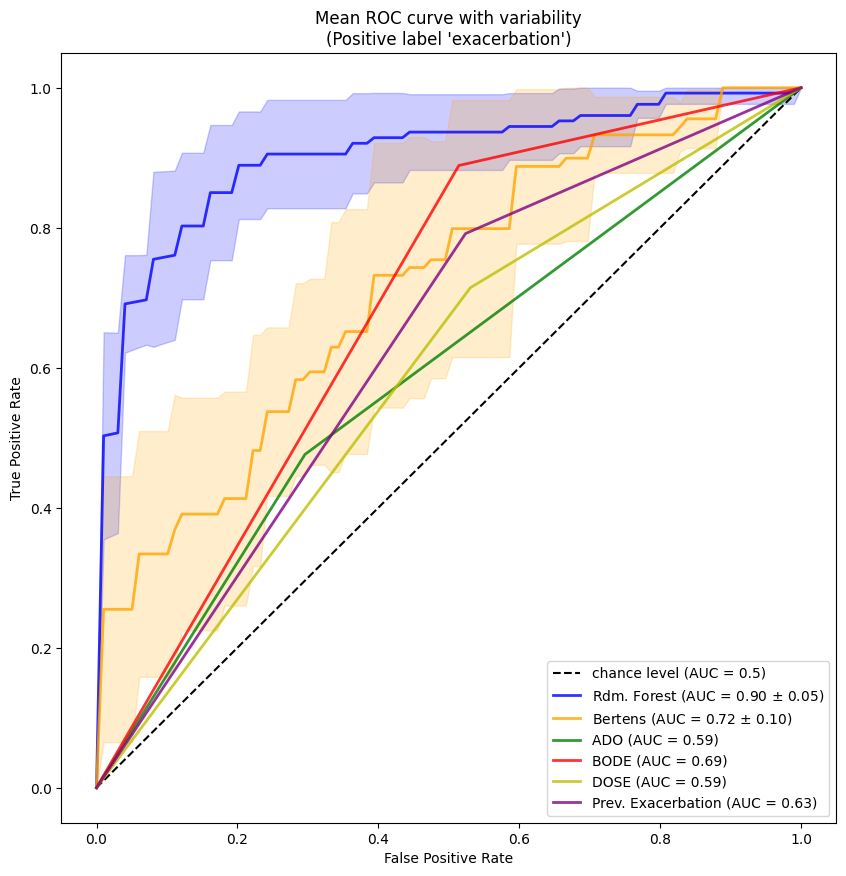

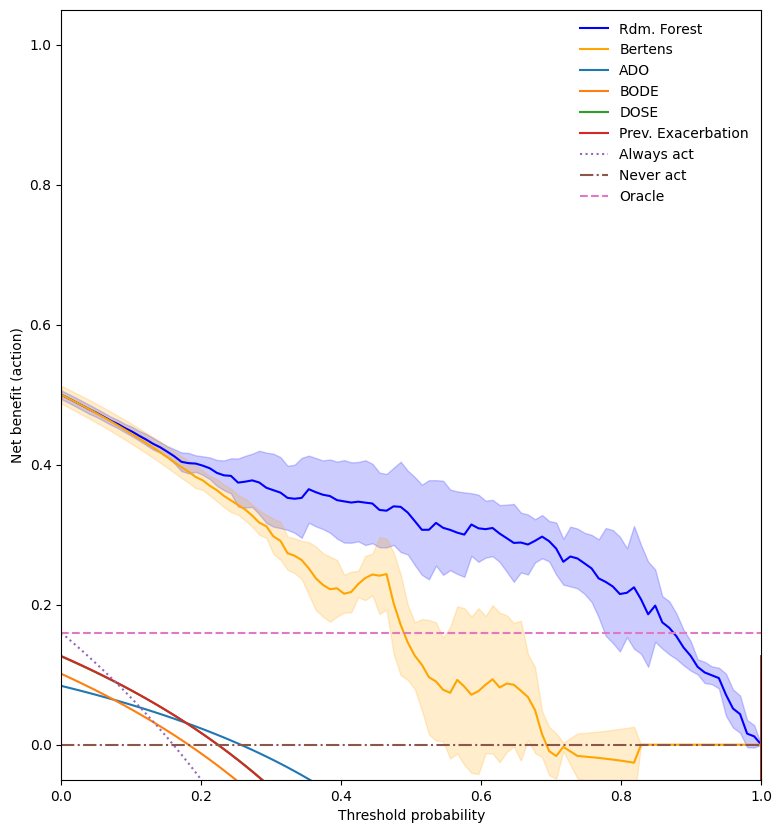

In [37]:
# TODO exacerbation history alone


# create ROC plot for random forest
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
# create 100 random folds of the harvard data
from sklearn.model_selection import StratifiedKFold
from statkit.decision import NetBenefitDisplay
from sklearn.linear_model import LogisticRegression
harvard_preprocessed = pd.read_csv('harvard/data/triage_cv.csv', sep=";")


# TODO variable selection
X_rf = harvard_preprocessed.drop(columns=['target']).to_numpy()
y = harvard_preprocessed['target'].to_numpy()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
rf = RandomForestClassifier(n_estimators=100, criterion='entropy',max_depth=10, max_features='auto', n_jobs=-1)

rf_tprs = []
rf_aucs = []
rf_mean_fpr = np.linspace(0, 1, 100)

# create a 1x2 figure
fig, ax_roc = plt.subplots(figsize=(10, 10))
fig, ax_nb = plt.subplots(figsize=(10, 10))
# plot random guess line
ax_roc.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

# plot the rf roc curve with variability
for fold, (train, test) in enumerate(cv.split(X_rf, y)):
    # print(train.shape)
    # print(test.shape)
    rf.fit(X_rf[train], y[train])
    # do not display the plot in the legend
    rf_viz = RocCurveDisplay.from_estimator(
        rf,
        X_rf[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax_roc,
    )
    # hide the folds
    rf_viz.line_.set_visible(False)
    rf_viz.line_.set_label(None)
    # hide the legend handle for the folds
    rf_interp_tpr = np.interp(rf_mean_fpr, rf_viz.fpr, rf_viz.tpr)
    rf_interp_tpr[0] = 0.0
    rf_tprs.append(rf_interp_tpr)
    rf_aucs.append(rf_viz.roc_auc)

    y_pred = rf.predict_proba(X_rf[test])[:, 1]
    rf_nb = NetBenefitDisplay.from_predictions(y[test], y_pred, ax=ax_nb, benefit_type='action',  show_references=False)
    
    # accuracy = rf.score(X_rf[test], y[test])
    # print(f"Accuracy (fold {fold}): {accuracy}")

# get the line data of the last 5 lines on the ax[1] plot
rf_nb_lines = ax_nb.get_lines()[-5:]
# remove these lines from the plot
for line in rf_nb_lines:
    line.remove()
# calculate the mean of the lines
rf_nb_mean = np.mean([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# calculate the std of the lines
rf_nb_std = np.std([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# plot the mean and std
ax_nb.plot(rf_nb_mean[:, 0], rf_nb_mean[:, 1], color="b", label=r"Rdm. Forest")
ax_nb.fill_between(
    rf_nb_mean[:, 0],
    rf_nb_mean[:, 1] - rf_nb_std[:, 1],
    rf_nb_mean[:, 1] + rf_nb_std[:, 1],
    alpha=0.2,
    color="b",
)


rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(rf_mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
ax_roc.plot(
    rf_mean_fpr,
    rf_mean_tpr,
    color="b",
    label=r"Rdm. Forest (AUC = %0.2f $\pm$ %0.2f)" % (rf_mean_auc, rf_std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(rf_tprs, axis=0)
tprs_upper = np.minimum(rf_mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(rf_mean_tpr - std_tpr, 0)
ax_roc.fill_between(
    rf_mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
    label = None
)



lr = LogisticRegression()
bertens_tprs = []
bertens_aucs = []
bertens_mean_fpr = np.linspace(0, 1, 100)
# Bertens
for fold, (train, test) in enumerate(cv.split(X_bertens, y_bertens)):
    lr.fit(X_bertens[train], y_bertens[train])
    # do not display the plot in the legend
    bertens_viz = RocCurveDisplay.from_estimator(
        lr,
        X_bertens[test],
        y_bertens[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax_roc,
    )
    # hide the folds
    bertens_viz.line_.set_visible(False)
    bertens_viz.line_.set_label(None)
    # hide the legend handle for the folds
    bertens_interp_tpr = np.interp(bertens_mean_fpr, bertens_viz.fpr, bertens_viz.tpr)
    bertens_interp_tpr[0] = 0.0
    bertens_tprs.append(bertens_interp_tpr)
    bertens_aucs.append(bertens_viz.roc_auc)
    y_pred = lr.predict_proba(X_bertens[test])[:, 1]
    bertens_nb = NetBenefitDisplay.from_predictions(y_bertens[test].ravel(), y_pred, ax=ax_nb, benefit_type='action',  show_references=False)

# get the line data of the last 5 lines on the ax[1] plot
rf_nb_lines = ax_nb.get_lines()[-5:]
# remove these lines from the plot
for line in rf_nb_lines:
    line.remove()
# calculate the mean of the lines
rf_nb_mean = np.mean([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# calculate the std of the lines
rf_nb_std = np.std([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# plot the mean and std
ax_nb.plot(rf_nb_mean[:, 0], rf_nb_mean[:, 1], color="orange", label=r"Bertens")
ax_nb.fill_between(
    rf_nb_mean[:, 0],
    rf_nb_mean[:, 1] - rf_nb_std[:, 1],
    rf_nb_mean[:, 1] + rf_nb_std[:, 1],
    alpha=0.2,
    color="orange",
)


bertens_mean_tpr = np.mean(bertens_tprs, axis=0)
bertens_mean_tpr[-1] = 1.0
bertens_mean_auc = auc(bertens_mean_fpr, bertens_mean_tpr)
bertens_std_auc = np.std(bertens_aucs)
ax_roc.plot(
    bertens_mean_fpr,
    bertens_mean_tpr,
    color="orange",
    label=r"Bertens (AUC = %0.2f $\pm$ %0.2f)" % (bertens_mean_auc, bertens_std_auc),
    lw=2,
    alpha=0.8,
)

bertens_std_tpr = np.std(bertens_tprs, axis=0)
bertens_tprs_upper = np.minimum(bertens_mean_tpr + bertens_std_tpr, 1)
bertens_tprs_lower = np.maximum(bertens_mean_tpr - bertens_std_tpr, 0)
ax_roc.fill_between(
    bertens_mean_fpr,
    bertens_tprs_lower,
    bertens_tprs_upper,
    color="orange",
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
    label = None
)

ax_roc.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'exacerbation')",
)

ax_nb.set(
    xlim=[0, 1],
    ylim=[0, 1],
    xlabel="Threshold Probability",
    ylabel="Preference",
    title=f"",
)

# ADO
y_ado = ado['exacerbation']
y_pred_ado = np.where(ado['ADO'] > best_ado_cutoff, 1, 0)
ado_fpr, ado_tpr, ado_thresholds = roc_curve(y_ado, y_pred_ado)
ado_auc = auc(ado_fpr, ado_tpr)
ax_roc.plot(
    ado_fpr,
    ado_tpr,
    color="g",
    label=r"ADO (AUC = %0.2f) " % (ado_auc),
    lw=2,
    alpha=0.8,
)


NetBenefitDisplay.from_predictions(y_ado, y_pred_ado, ax=ax_nb, benefit_type='action', name="ADO", show_references=False)


# BODE
y_bode = bode['exacerbation']
y_pred_bode = np.where(bode['BODE'] > best_bode_cutoff, 1, 0)
bode_fpr, bode_tpr, bode_thresholds = roc_curve(y_bode, y_pred_bode)
bode_auc = auc(bode_fpr, bode_tpr)
ax_roc.plot(
    bode_fpr,
    bode_tpr,
    color="r",
    label=r"BODE (AUC = %0.2f)" % (bode_auc),
    lw=2,
    alpha=0.8,
)
NetBenefitDisplay.from_predictions(y_bode, y_pred_bode, ax=ax_nb, benefit_type='action', name="BODE", show_references=False)

# DOSE
y_dose = dose['exacerbation']
y_pred_dose = np.where(dose['DOSE'] > best_dose_cutoff, 1, 0)
dose_fpr, dose_tpr, dose_thresholds = roc_curve(y_dose, y_pred_dose)
dose_auc = auc(dose_fpr, dose_tpr)
ax_roc.plot(
    dose_fpr,
    dose_tpr,
    color="y",
    label=r"DOSE (AUC = %0.2f)" % (dose_auc),
    lw=2,
    alpha=0.8,
)

NetBenefitDisplay.from_predictions(y_dose, y_pred_dose, ax=ax_nb, benefit_type='action', name="DOSE", show_references=False)

# prev exacerbation
y_prev_ex = prev_exa['exacerbation']
y_pred_prev_ex = np.where(prev_exa['prev_exacerbations'] > best_prev_exa_cutoff, 1, 0)
prev_exa_fpr, prev_exa_tpr, prev_exa_thresholds = roc_curve(y_prev_ex, y_pred_prev_ex)
prev_exa_auc = auc(prev_exa_fpr, prev_exa_tpr)
ax_roc.plot(
    prev_exa_fpr,
    prev_exa_tpr,
    color="purple",
    label=r"Prev. Exacerbation (AUC = %0.2f)" % (prev_exa_auc),
    lw=2,
    alpha=0.8,
)

NetBenefitDisplay.from_predictions(y_prev_ex, y_pred_prev_ex, ax=ax_nb, benefit_type='action', name="Prev. Exacerbation", show_references=True)

plt.gca().set_aspect('equal')
ax_roc.legend(loc="lower right")
ax_roc.legend(loc="lower right")
# only show the mean roc curve
plt.show()
# save svg
ax_roc.get_figure().savefig("plots/roc_curve_harvard_2.svg", format="svg")
ax_nb.get_figure().savefig("plots/net_benefit_harvard_2.svg", format="svg")
    

# Triage

## Preprocessing

In [25]:
triage = pd.read_excel('./triage/data/data.xlsx')

# remove all empty rows
triage = triage.dropna(how='all')

# drop Alternate Diagnosis? (y/n), Final Triage 1 (1-4), Confidence 1 (%), Final Triage 2 (1-4), Confidence 2 (%), Highly Unrealistic Case (Y), Highly Uncertain (Y), Profile Severity (1-5)
triage = triage.drop(columns=['Unnamed: 0', 'Alternate Diagnosis? (y/n)', 'Final Triage 1 (1-4)', 'Confidence 1 (%)', 'Final Triage 2 (1-4)', 'Confidence 2 (%)', 'Highly Unrealistic Case (Y)', 'Highly Uncertain (Y)', 'Profile Severity (1-5)'], axis=1)
# reset index
triage = triage.reset_index(drop=True)


triage = triage.drop(triage.columns[triage.columns.get_loc('Exacerbation (Y/N)') + 1:], axis=1)
# drop Vitals Severity (1-5)
triage = triage.drop(columns=['Vitals Severity (1-5)'], axis=1)
# convert all values where it say 'Unknown' to NaN
triage = triage.replace('Unknown', np.nan)

# turn Male into 1 and Female into 0
triage = triage.replace('Male', 1)
triage = triage.replace('Female', 0)

# convert height from Height(ft) and Height(in) to Height(cm)
triage['Height(cm)'] = triage['Height(ft)'] * 30.48 + triage['Height(in)'] * 2.54
# drop Height(ft) and Height(in)
triage = triage.drop(columns=['Height(ft)', 'Height(in)'], axis=1)

# convert weight from Weight(lbs) to Weight(kg)
triage['Weight(kg)'] = triage['Weight (lb)'] * 0.45359237
# drop Weight(lbs)
triage = triage.drop(columns=['Weight (lb)'], axis=1)

# recalculate BMI for metric system
triage['BMI'] = triage['Weight(kg)'] / (triage['Height(cm)'] / 100) ** 2

# convert temperature from Temperature(F) to Temperature(C)
triage['Current Temperature'] = (triage['Current Temperature'] - 32) * 5 / 9


risk_factors = ()
# add all unique values in columns Risk Factor 1-4 to risk_factors, make sure there are no duplicates
for i in range(1, 5):
    risk_factors += tuple(triage['Risk Factor ' + str(i)].unique())
risk_factors = tuple(set(risk_factors))
# remove NaN from risk_factors
risk_factors = tuple(filter(lambda x: x == x, risk_factors))
# create a column for each risk factor in risk_factors
for risk_factor in risk_factors:
    triage[risk_factor] = 0
# set all values in the columns to 1 if the risk factor is present
for i in range(1, 5):
    for risk_factor in risk_factors:
        triage.loc[triage['Risk Factor ' + str(i)] == risk_factor, risk_factor] = 1
# drop Risk Factor 1-4
triage = triage.drop(columns=['Risk Factor ' + str(i) for i in range(1, 5)], axis=1)

medications = ()
# split each value in 'Current Medication' at + and add the medication to the tuple if it is not already in there
for medication in triage['Current Medication']:
    # if the value is not empty
    if medication == medication:
        # split the value at + and add the medication to the tuple if it is not already in there
        for med in str(medication).split('+'):
            if med not in medications:
                medications += (med,)



# create a column for each medication in medications
for medication in medications:
    triage[medication] = 0
# set all values in the columns to 1 if the medication is present
for medication in medications:
    triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1
# drop Current Medication
triage = triage.drop(columns=['Current Medication'], axis=1)

# turn Baseline Dyspnea (MMRC) into the number that the value contains
triage['Baseline Dyspnea (MMRC)'] = triage['Baseline Dyspnea (MMRC)'].str.extract('(\d+)')
# turn COPD Gold Stage into the number that the value contains
triage['COPD Gold Stage'] = triage['COPD Gold Stage'].str.extract('(\d+)')
# turn Recent Worsening in Symptoms? into categorical values for each unique values
triage['Recent Worsening in Symptoms?'] = triage['Recent Worsening in Symptoms?'].astype('category').cat.codes
# turn % Controller Medication Taken Over Last Week into categorical values for each unique values
triage['% Controller Medication Taken Over Last Week'] = triage['% Controller Medication Taken Over Last Week'].astype('category').cat.codes
# turn Short of Breath? into categorical values for each unique values
triage['Short of Breath?'] = triage['Short of Breath?'].astype('category').cat.codes
# turn Cough? into categorical values for each unique values
triage['Cough?'] = triage['Cough?'].astype('category').cat.codes
# turn Sputum? into categorical values for each unique values
triage['Sputum?'] = triage['Sputum?'].astype('category').cat.codes
# turn Wheezing? into categorical values for each unique values
triage['Wheezing?'] = triage['Wheezing?'].astype('category').cat.codes

# turn Current Dyspnea (MMRC) into the number that the value contains
triage['Current Dyspnea (MMRC)'] = triage['Current Dyspnea (MMRC)'].str.extract('(\d+)')

# turn all values that contain 'No' into 0 and all values that contain 'Yes' into 1
triage = triage.replace('No', 0)
triage = triage.replace('Yes', 1)
triage = triage.replace('Y', 1)
triage = triage.replace('y', 0)
triage = triage.replace('N', 0)

# print missing values
print(triage.isnull().sum())

categorical_vars = ['COPD Gold Stage']
# impute using mode
for var in categorical_vars:
    triage[var].fillna(triage[var].mode()[0], inplace=True)



numerical_vars = ['Baseline FEV1', 'Baseline Heart Rate', 'Baseline Pulse Ox', 'Baseline Heart Rate.1', 'Baseline Pulse Ox.1', 'Current Heart Rate', 'Current Pulse Ox', 'Current Temperature', 'Current FEV1 (% Predicted)', 'Baseline FEV1 (% Predicted)']

# impute using median
for var in numerical_vars:
    triage[var].fillna(triage[var].median(), inplace=True)

# create fever variable
# triage['fever'] = 0
# triage.loc[triage['Current Temperature'] > 38, 'fever'] = 1
# # drop Current Temperature
# triage = triage.drop(columns=['Current Temperature'], axis=1)

# scaling
scaler = MinMaxScaler()
target = triage['Exacerbation (Y/N)']
triage = triage.drop(columns=['Exacerbation (Y/N)'], axis=1)
triage = pd.DataFrame(scaler.fit_transform(triage), columns=triage.columns)
triage['Exacerbation (Y/N)'] = target

# target variable
# print(triage['Exacerbation (Y/N)'].value_counts())
# balance using smote
sm = SMOTE(random_state=42)
X = triage.drop(columns=['Exacerbation (Y/N)'], axis=1)
y = triage['Exacerbation (Y/N)']
X, y = sm.fit_resample(X, y)
triage = X
triage['Exacerbation (Y/N)'] = y

# without current temperature for now

relevant_vars = [
    'Age', 
    'Gender', 
    'BMI', 
    'Baseline Dyspnea (MMRC)', 
    'COPD Gold Stage', 
    'Cough?', 'Sputum?', 'Wheezing?', 
    'Baseline FEV1', 
    # 'Current FEV1 (% Predicted)', 
    'Baseline FEV1 (% Predicted)', 
    'Exacerbation (Y/N)', 
    'Respiratory Symptoms Wake You Up At Night More Than Usual?', 
    '2 or More Exacerbations In Last Year', 
    'High Blood Pressure', 
    'Coronary Artery Disease', 
    'Congestive Heart Failure', 
    'Asthma', 
    'Needs Help Performing Daily Activities', 
    'Chronic Kidney Disease',  
    'Diabetes', 
    'Visited ICU for COPD in Last Year', 
    'Hospitalized for COPD in Last Year', 
    'Smoker', 
    'Pill for Controlling Exacerbations ', 
    ' Prescribed Inhaler ', 
    ' Rescue Inhaler As Needed', 
    'Prescribed Inhaler (Azithromycin or Roflumilast) ', 
    ' rescue Inhaler As Needed.', 
    'Rescue Inhaler Or Nebulizer As Needed For Breathing', ]

triage = triage[relevant_vars]

# rename vars
triage = triage.rename(columns={
    "Age":"age", 
    "Gender":"gender", 
    "BMI":"bmi", 
    "Baseline Dyspnea (MMRC)":"mmrc", 
    "COPD Gold Stage":"gold", 
    "Cough?":"cough", 
    "Sputum?":"sputum", 
    "Wheezing?":"wheezing", 
    "Baseline FEV1":"fev1", 
    "Current Temperature":"temperature", 
    "Current FEV1 (% Predicted)":"percent_fev1_pred_current", 
    "Baseline FEV1 (% Predicted)":"percent_fev1_pred", 
    "Exacerbation (Y/N)":"target", 
    "Respiratory Symptoms Wake You Up At Night More Than Usual?":"waking_up_at_night", 
    "2 or More Exacerbations In Last Year":"two_exacerbations_last_year", 
    "High Blood Pressure":"hypertension", 
    "Coronary Artery Disease":"ischemic_heart_disease", 
    "Congestive Heart Failure":"heart_failure", 
    "Asthma":"asthma", 
    "Needs Help Performing Daily Activities":"daily_activities_restricted", 
    "Chronic Kidney Disease":"chronic_kidney_disease",  
    "Diabetes":"diabetes", 
    "Visited ICU for COPD in Last Year":"icu", 
    "Hospitalized for COPD in Last Year":"hospitalization", 
    "Smoker":"smoker", 
    "Pill for Controlling Exacerbations ":"pill_for_exa", 
    " Prescribed Inhaler ":"medication_inhaler", 
    " Rescue Inhaler As Needed":"medication_rescue_inhaler", 
    "Prescribed Inhaler (Azithromycin or Roflumilast) ":"medication_azithromycin_roflumilast", 
    " rescue Inhaler As Needed.":"medication_rescue_inhaler_as_needed", 
    "Rescue Inhaler Or Nebulizer As Needed For Breathing":"medication_rescue_inhaler_or_nebulizer"})

# perform some feature engineering
triage["inhaler"] = 0
if triage["medication_inhaler"].any() == 1 or triage["medication_rescue_inhaler"].any() == 1 or triage["medication_rescue_inhaler_as_needed"].any() == 1 or triage["medication_rescue_inhaler_or_nebulizer"].any() == 1 or triage["medication_azithromycin_roflumilast"].any() == 1:
    triage["inhaler"] = 1

# drop unnecessary columns
triage = triage.drop(columns=["medication_inhaler", "medication_rescue_inhaler", "medication_rescue_inhaler_as_needed", "medication_rescue_inhaler_or_nebulizer", "medication_azithromycin_roflumilast", "daily_activities_restricted", 'fev1'], axis=1)

# triage['fever'] = 0
# triage.loc[triage['temperature'] > 38, 'fever'] = 1

# sort the columns
triage = triage.reindex(sorted(triage.columns), axis=1)

# export as harvard_cv
# triage.to_csv("../triage/data/harvard_cv.csv", index=False, sep=";")

Gender                                                         0
Age                                                            0
BMI                                                            0
Baseline Dyspnea (MMRC)                                        0
COPD Gold Stage                                               32
Baseline FEV1                                                 32
Baseline Heart Rate                                           30
Baseline Pulse Ox                                             36
Recent Worsening in Symptoms?                                  0
% Controller Medication Taken Over Last Week                   0
Short of Breath?                                               0
Cough?                                                         0
Wheezing?                                                      0
Sputum?                                                        0
Current Dyspnea (MMRC)                                         0
Infection?               

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\4151819099.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1


## Random Forest

## ADO

In [26]:
# age, mmrc, fev1 % predicted is possible

ado_triage = triage[['target', 'age', 'mmrc', 'percent_fev1_pred']]

# create a column for ADO score
ado_triage['ADO'] = 0
# if age is between 50 and 59 add 2 points
ado_triage.loc[(ado_triage['age'] >= 50) & (ado_triage['age'] <= 59), 'ADO'] += 2
# if age is between 60 and 69 add 4 points
ado_triage.loc[(ado_triage['age'] >= 60) & (ado_triage['age'] <= 69), 'ADO'] += 4
# if age is between 70 and 79 add 5 points
ado_triage.loc[(ado_triage['age'] >= 70) & (ado_triage['age'] <= 79), 'ADO'] += 5
# if age is above 80 add 7 points
ado_triage.loc[ado_triage['age'] >= 80, 'ADO'] += 7
# if mmrc is 3 add 2 points
ado_triage.loc[ado_triage['mmrc'] == 3, 'ADO'] += 2
# if mmrc is 4 add 3 points
ado_triage.loc[ado_triage['mmrc'] == 4, 'ADO'] += 3
# if fev1% is between 51 and 64 add 2 points
ado_triage.loc[(ado_triage['percent_fev1_pred'] >= 51) & (ado_triage['percent_fev1_pred'] <= 64), 'ADO'] += 2
# if fev1% is between 36 and 50 add 3 points
ado_triage.loc[(ado_triage['percent_fev1_pred'] >= 36) & (ado_triage['percent_fev1_pred'] <= 50), 'ADO'] += 3
# if fev1% is smaller than 35 add 4 points
ado_triage.loc[ado_triage['percent_fev1_pred'] < 35, 'ADO'] += 4


# get best cutoff for ADO score
ado_cutoffs = np.linspace(0, ado['ADO'].max(), 100)
ado_scores = []
for cutoff in ado_cutoffs:
    y = ado['exacerbation']
    y_pred = np.where(ado['ADO'] > cutoff, 1, 0)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # calculate AUC score from TPR and FPR
    auc_score = auc(fpr, tpr)
    # add AUC score to list
    ado_scores.append(auc_score)
# get the cutoff with the highest AUC score
best_ado_triage_cutoff = ado_cutoffs[ado_scores.index(max(ado_scores))]
# print the cutoff
print('ADO cutoff: ' + str(best_ado_triage_cutoff))
print('ADO AUC score: ' + str(max(ado_scores)))


ADO cutoff: 7.090909090909092
ADO AUC score: 0.5901360544217686


C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\2332554622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ado_triage['ADO'] = 0
C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\2332554622.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ado_triage.loc[ado_triage['percent_fev1_pred'] < 35, 'ADO'] += 4


## DOSE

In [31]:
# mmrc, smoking status, exacerbation history, fev1%pred is possible
dose_triage = triage[['target', 'mmrc', 'smoker', 'two_exacerbations_last_year', 'percent_fev1_pred']]

dose_triage['DOSE'] = 0

dose_triage.loc[(dose_triage['mmrc'] == 2), 'DOSE'] += 1
dose_triage.loc[(dose_triage['mmrc'] == 3), 'DOSE'] += 2
dose_triage.loc[(dose_triage['mmrc'] == 4), 'DOSE'] += 3

dose_triage.loc[(dose_triage['percent_fev1_pred'] >= 30) & (dose_triage['percent_fev1_pred'] <= 49), 'DOSE'] += 1
dose_triage.loc[(dose_triage['percent_fev1_pred'] < 30), 'DOSE'] += 2

# if participant is smoker add 1 point
dose_triage.loc[dose_triage['smoker'] == 1, 'DOSE'] += 1

# prev exacerbations is badly categorized. For now we assume that category 3 is given for this
dose_triage.loc[(dose_triage['two_exacerbations_last_year'] == 3), 'DOSE'] += 2

# get best cutoff for DOSE score
dose_cutoffs = np.linspace(0, dose_triage['DOSE'].max(), 100)
dose_scores = []
for cutoff in dose_cutoffs:
    y = dose_triage['target']
    y_pred = np.where(dose_triage['DOSE'] > cutoff, 1, 0)
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # calculate AUC score from TPR and FPR
    auc_score = auc(fpr, tpr)
    # add AUC score to list
    dose_scores.append(auc_score)
# get the cutoff with the highest AUC score
best_dose_triage_cutoff = dose_cutoffs[dose_scores.index(max(dose_scores))]
# print the cutoff
print('DOSE cutoff: ' + str(best_dose_triage_cutoff))
print('DOSE AUC score: ' + str(max(dose_scores)))

DOSE cutoff: 2.0
DOSE AUC score: 0.5514705882352942


C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\1061392126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_triage['DOSE'] = 0
C:\Users\Daniel\AppData\Local\Temp\ipykernel_23736\1061392126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_triage.loc[(dose_triage['percent_fev1_pred'] < 30), 'DOSE'] += 2


## BODE

## Prev Exacerbations

In [48]:
prev_exa_triage = triage[['target', 'two_exacerbations_last_year']]

## Bertens 
This is impossible currently because pack years is missing

In [43]:
# use hypertension, coronary aretery disease, congestive heart failure, pulmonary hypertension as a proxy for stroke

bertens = triage[['percent_fev1_pred', 'target', 'two_exacerbations_last_year', 'ischemic_heart_disease','heart_failure', 'hypertension']]

# deal with missing values
bertens = bertens.dropna()

# perform minmax scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
bertens[['percent_fev1_pred']] = scaler.fit_transform(bertens[['percent_fev1_pred']])

# balance target using smote
from imblearn.over_sampling import SMOTE
X = bertens.drop(['target'], axis=1)
y = bertens['target']
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_bertens = pd.DataFrame(X_res, columns=X.columns).to_numpy()
y_bertens = pd.DataFrame(y_res, columns=['target']).to_numpy()


## ROC Curve and Net Benefit

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
No artists with labels found to put in legend.  Note that artists whose lab

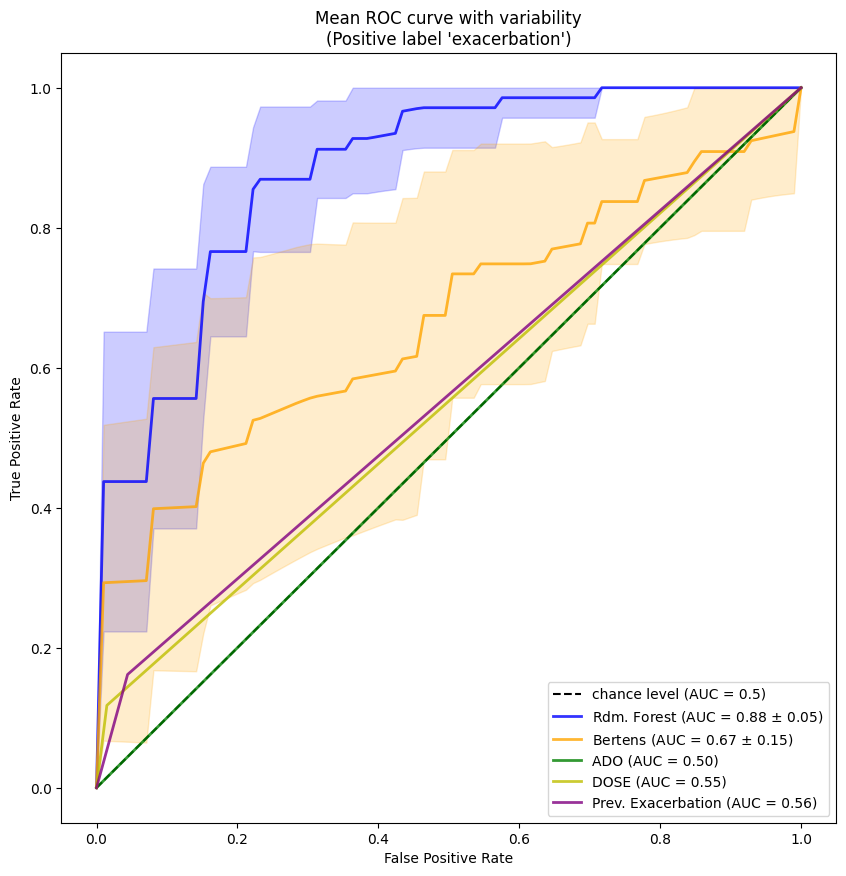

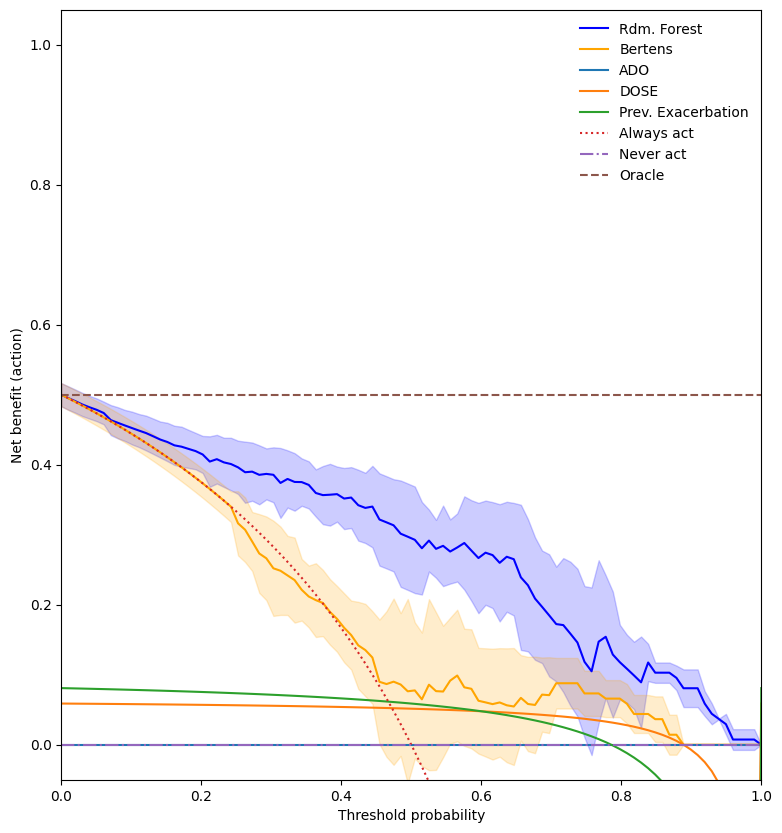

In [49]:
## ROC Curve

# TODO exacerbation history alone


# create ROC plot for random forest
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
# create 100 random folds of the harvard data
from sklearn.model_selection import StratifiedKFold
from statkit.decision import NetBenefitDisplay
from sklearn.linear_model import LogisticRegression
harvard_preprocessed = pd.read_csv('harvard/data/triage_cv.csv', sep=";")


# TODO variable selection
X_rf_triage = triage.drop(columns=['target']).to_numpy()
y_triage = triage['target'].to_numpy()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
rf = RandomForestClassifier(n_estimators=100, criterion='entropy',max_depth=10, max_features='auto', n_jobs=-1)

rf_tprs = []
rf_aucs = []
rf_mean_fpr = np.linspace(0, 1, 100)

# create a 1x2 figure
fig, ax_roc = plt.subplots(figsize=(10, 10))
fig, ax_nb = plt.subplots(figsize=(10, 10))
# plot random guess line
ax_roc.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

# plot the rf roc curve with variability
for fold, (train, test) in enumerate(cv.split(X_rf_triage, y_triage)):
    # print(train.shape)
    # print(test.shape)
    rf.fit(X_rf_triage[train], y_triage[train])
    # do not display the plot in the legend
    rf_viz = RocCurveDisplay.from_estimator(
        rf,
        X_rf_triage[test],
        y_triage[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax_roc,
    )
    # hide the folds
    rf_viz.line_.set_visible(False)
    rf_viz.line_.set_label(None)
    # hide the legend handle for the folds
    rf_interp_tpr = np.interp(rf_mean_fpr, rf_viz.fpr, rf_viz.tpr)
    rf_interp_tpr[0] = 0.0
    rf_tprs.append(rf_interp_tpr)
    rf_aucs.append(rf_viz.roc_auc)

    y_pred = rf.predict_proba(X_rf_triage[test])[:, 1]
    rf_nb = NetBenefitDisplay.from_predictions(y_triage[test], y_pred, ax=ax_nb, benefit_type='action',  show_references=False)
    
    # accuracy = rf.score(X_rf[test], y[test])
    # print(f"Accuracy (fold {fold}): {accuracy}")

# get the line data of the last 5 lines on the ax[1] plot
rf_nb_lines = ax_nb.get_lines()[-5:]
# remove these lines from the plot
for line in rf_nb_lines:
    line.remove()
# calculate the mean of the lines
rf_nb_mean = np.mean([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# calculate the std of the lines
rf_nb_std = np.std([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# plot the mean and std
ax_nb.plot(rf_nb_mean[:, 0], rf_nb_mean[:, 1], color="b", label=r"Rdm. Forest")
ax_nb.fill_between(
    rf_nb_mean[:, 0],
    rf_nb_mean[:, 1] - rf_nb_std[:, 1],
    rf_nb_mean[:, 1] + rf_nb_std[:, 1],
    alpha=0.2,
    color="b",
)


rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(rf_mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
ax_roc.plot(
    rf_mean_fpr,
    rf_mean_tpr,
    color="b",
    label=r"Rdm. Forest (AUC = %0.2f $\pm$ %0.2f)" % (rf_mean_auc, rf_std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(rf_tprs, axis=0)
tprs_upper = np.minimum(rf_mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(rf_mean_tpr - std_tpr, 0)
ax_roc.fill_between(
    rf_mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
    label = None
)



lr = LogisticRegression()
bertens_tprs = []
bertens_aucs = []
bertens_mean_fpr = np.linspace(0, 1, 100)
# Bertens
for fold, (train, test) in enumerate(cv.split(X_bertens, y_bertens)):
    lr.fit(X_bertens[train], y_bertens[train])
    # do not display the plot in the legend
    bertens_viz = RocCurveDisplay.from_estimator(
        lr,
        X_bertens[test],
        y_bertens[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax_roc,
    )
    # hide the folds
    bertens_viz.line_.set_visible(False)
    bertens_viz.line_.set_label(None)
    # hide the legend handle for the folds
    bertens_interp_tpr = np.interp(bertens_mean_fpr, bertens_viz.fpr, bertens_viz.tpr)
    bertens_interp_tpr[0] = 0.0
    bertens_tprs.append(bertens_interp_tpr)
    bertens_aucs.append(bertens_viz.roc_auc)
    y_pred = lr.predict_proba(X_bertens[test])[:, 1]
    bertens_nb = NetBenefitDisplay.from_predictions(y_bertens[test].ravel(), y_pred, ax=ax_nb, benefit_type='action',  show_references=False)

# get the line data of the last 5 lines on the ax[1] plot
rf_nb_lines = ax_nb.get_lines()[-5:]
# remove these lines from the plot
for line in rf_nb_lines:
    line.remove()
# calculate the mean of the lines
rf_nb_mean = np.mean([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# calculate the std of the lines
rf_nb_std = np.std([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# plot the mean and std
ax_nb.plot(rf_nb_mean[:, 0], rf_nb_mean[:, 1], color="orange", label=r"Bertens")
ax_nb.fill_between(
    rf_nb_mean[:, 0],
    rf_nb_mean[:, 1] - rf_nb_std[:, 1],
    rf_nb_mean[:, 1] + rf_nb_std[:, 1],
    alpha=0.2,
    color="orange",
)


bertens_mean_tpr = np.mean(bertens_tprs, axis=0)
bertens_mean_tpr[-1] = 1.0
bertens_mean_auc = auc(bertens_mean_fpr, bertens_mean_tpr)
bertens_std_auc = np.std(bertens_aucs)
ax_roc.plot(
    bertens_mean_fpr,
    bertens_mean_tpr,
    color="orange",
    label=r"Bertens (AUC = %0.2f $\pm$ %0.2f)" % (bertens_mean_auc, bertens_std_auc),
    lw=2,
    alpha=0.8,
)

bertens_std_tpr = np.std(bertens_tprs, axis=0)
bertens_tprs_upper = np.minimum(bertens_mean_tpr + bertens_std_tpr, 1)
bertens_tprs_lower = np.maximum(bertens_mean_tpr - bertens_std_tpr, 0)
ax_roc.fill_between(
    bertens_mean_fpr,
    bertens_tprs_lower,
    bertens_tprs_upper,
    color="orange",
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
    label = None
)

ax_roc.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'exacerbation')",
)

ax_nb.set(
    xlim=[0, 1],
    ylim=[0, 1],
    xlabel="Threshold Probability",
    ylabel="Preference",
    title=f"",
)

# ADO
y_ado = ado_triage['target']
y_pred_ado = np.where(ado_triage['ADO'] > best_ado_triage_cutoff, 1, 0)
ado_fpr, ado_tpr, ado_thresholds = roc_curve(y_ado, y_pred_ado)
ado_auc = auc(ado_fpr, ado_tpr)
ax_roc.plot(
    ado_fpr,
    ado_tpr,
    color="g",
    label=r"ADO (AUC = %0.2f) " % (ado_auc),
    lw=2,
    alpha=0.8,
)


NetBenefitDisplay.from_predictions(y_ado, y_pred_ado, ax=ax_nb, benefit_type='action', name="ADO", show_references=False)


# # BODE
# y_bode = bode['exacerbation']
# y_pred_bode = np.where(bode['BODE'] > best_bode_cutoff, 1, 0)
# bode_fpr, bode_tpr, bode_thresholds = roc_curve(y_bode, y_pred_bode)
# bode_auc = auc(bode_fpr, bode_tpr)
# ax_roc.plot(
#     bode_fpr,
#     bode_tpr,
#     color="r",
#     label=r"BODE (AUC = %0.2f)" % (bode_auc),
#     lw=2,
#     alpha=0.8,
# )
# NetBenefitDisplay.from_predictions(y_bode, y_pred_bode, ax=ax_nb, benefit_type='action', name="BODE", show_references=False)

# DOSE
y_dose = dose_triage['target']
y_pred_dose = np.where(dose_triage['DOSE'] > best_dose_triage_cutoff, 1, 0)
dose_fpr, dose_tpr, dose_thresholds = roc_curve(y_dose, y_pred_dose)
dose_auc = auc(dose_fpr, dose_tpr)
ax_roc.plot(
    dose_fpr,
    dose_tpr,
    color="y",
    label=r"DOSE (AUC = %0.2f)" % (dose_auc),
    lw=2,
    alpha=0.8,
)

NetBenefitDisplay.from_predictions(y_dose, y_pred_dose, ax=ax_nb, benefit_type='action', name="DOSE", show_references=False)

# prev exacerbation
y_prev_ex = prev_exa_triage['target']
y_pred_prev_ex = np.where(prev_exa_triage['two_exacerbations_last_year'] == 1, 1, 0)
prev_exa_fpr, prev_exa_tpr, prev_exa_thresholds = roc_curve(y_prev_ex, y_pred_prev_ex)
prev_exa_auc = auc(prev_exa_fpr, prev_exa_tpr)
ax_roc.plot(
    prev_exa_fpr,
    prev_exa_tpr,
    color="purple",
    label=r"Prev. Exacerbation (AUC = %0.2f)" % (prev_exa_auc),
    lw=2,
    alpha=0.8,
)

NetBenefitDisplay.from_predictions(y_prev_ex, y_pred_prev_ex, ax=ax_nb, benefit_type='action', name="Prev. Exacerbation", show_references=True)

plt.gca().set_aspect('equal')
ax_roc.legend(loc="lower right")
ax_roc.legend(loc="lower right")
# only show the mean roc curve
plt.show()
    